## Barcode Neutrality Analysis
This notebook is designed to test whether the specific barcode sequence is having a fitness effect in barcoded virus libraries. Conceptually, a small number of barcodes are represnted in a barcoded virus library many times over. These viruses are passaged a few times, and the proportion of each barcode is assessed at each step of the experiment.

### Experimental Notes
These data were generated in the following way:
- In a single replicate, 20 colonies were picked from a plate of barcoded HA or NA plasmids. These plasmids were grown and purified.
- In a single replicate, virus was generated containing either bcHA, bcNA, or both bcHA and bcNA segments.
- These viruses were passaged in technical duplicate.
- The barcodes were amplified from the viral supernatants and sequenced from the bcHA and/or bcNA segments, as appropriate.

### Import Python modules
Use [dms_tools2](https://jbloomlab.github.io/dms_tools2/) for barcode parsing and [plotnine](https://plotnine.readthedocs.io) for ggplot2-like plotting:

In [1]:
import glob
import os
import yaml
import pandas as pd
from IPython.display import display, HTML
from plotnine import *
import dms_tools2

In [2]:
with open('config.yaml') as f:
    config = yaml.load(f)
    
upstream = config['viral_barcode_upstream']
downstream = config['viral_barcode_downstream']
upstream_mismatch = config['viral_barcode_upstream_mismatch']
downstream_mismatch = config['viral_barcode_downstream_mismatch']
barcodelength = config['viral_barcode_length']
fastqfolder = config['fastqfolder']

sample_csv = 'sampledata.csv'
metadata_csv = 'metadata.csv'

results_dir = 'results'
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/ipykernel_launcher.py:2: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  


In [3]:
samples = pd.read_csv(sample_csv,comment="#").query('datatype == "viral_barcode_fastqs"')

pd.set_option('max.colwidth', -1)
display(HTML(samples.to_html(index=False)))

sample,datatype,gene,datafile
3_Rescue_bcHA_HA,viral_barcode_fastqs,fluHA,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
5_Rescue_bcHAbcNA_HA,viral_barcode_fastqs,fluHA,5-Rescue-bcHAbcNA-HA_S2_L001_R1_001.fastq.gz
6_Passage1_bcHA_HA,viral_barcode_fastqs,fluHA,6-Passage1-bcHA-HA_S3_L001_R1_001.fastq.gz
7_Passage1_bcHA_HA,viral_barcode_fastqs,fluHA,7-Passage1-bcHA-HA_S4_L001_R1_001.fastq.gz
10_Passage1_bcHAbcNA_HA,viral_barcode_fastqs,fluHA,10-Passage1-bcHAbcNA-HA_S5_L001_R1_001.fastq.gz
11_Passage1_bcHAbcNA_HA,viral_barcode_fastqs,fluHA,11-Passage1-bcHAbcNA-HA_S6_L001_R1_001.fastq.gz
12_Passage2_bcHA_HA,viral_barcode_fastqs,fluHA,12-Passage2-bcHA-HA_S7_L001_R1_001.fastq.gz
13_Passage2_bcHA_HA,viral_barcode_fastqs,fluHA,13-Passage2-bcHA-HA_S8_L001_R1_001.fastq.gz
16_Passage2_bcHAbcNA_HA,viral_barcode_fastqs,fluHA,16-Passage2-bcHAbcNA-HA_S9_L001_R1_001.fastq.gz
17_Passage2_bcHAbcNA_HA,viral_barcode_fastqs,fluHA,17-Passage2-bcHAbcNA-HA_S10_L001_R1_001.fastq.gz


In [4]:
barcodes_file = results_dir + '/' + 'barcodes.csv'
fates_file = results_dir + '/' + 'fates.csv'

if os.path.exists(barcodes_file) and os.path.exists(fates_file):
    barcodes = pd.read_csv(barcodes_file)
    fates = pd.read_csv(fates_file)
else:
    barcodes = []
    fates = []

    for tup in samples.itertuples(index=False):

        parser = dms_tools2.barcodes.IlluminaBarcodeParser(
                    bclen=barcodelength,
                    upstream=upstream[tup.gene],
                    downstream=downstream[tup.gene],
                    upstream_mismatch=upstream_mismatch,
                    downstream_mismatch=downstream_mismatch)

        if '.fastq.gz' in tup.datafile:
            r1files = tup.datafile.split(',')
            r1files = [fastqfolder + s for s in r1files]
        else:
            r1files = glob.glob(os.path.join(tup.datafile, '*R1*.fastq.gz'))

        assert len(r1files)

        print(f"\nReading viral barcodes for {tup.sample} from {len(r1files)} R1 files")
        print("The files are:")
        print(*r1files, sep = "\n")

        ibarcodes, ifates = parser.parse(r1files)

        barcodes.append(ibarcodes.assign(sample=tup.sample))
        fates.append(ifates.assign(sample=tup.sample))

    barcodes = pd.concat(barcodes)
    fates = pd.concat(fates)


    print(f'Writing barcodes to {barcodes_file}')
    barcodes.to_csv(barcodes_file)

    print(f'Writing barcodes to {fates_file}')
    fates.to_csv(fates_file)

## Examine "fates" of barcode reads
We look at how many of the barcode reads we could parse:

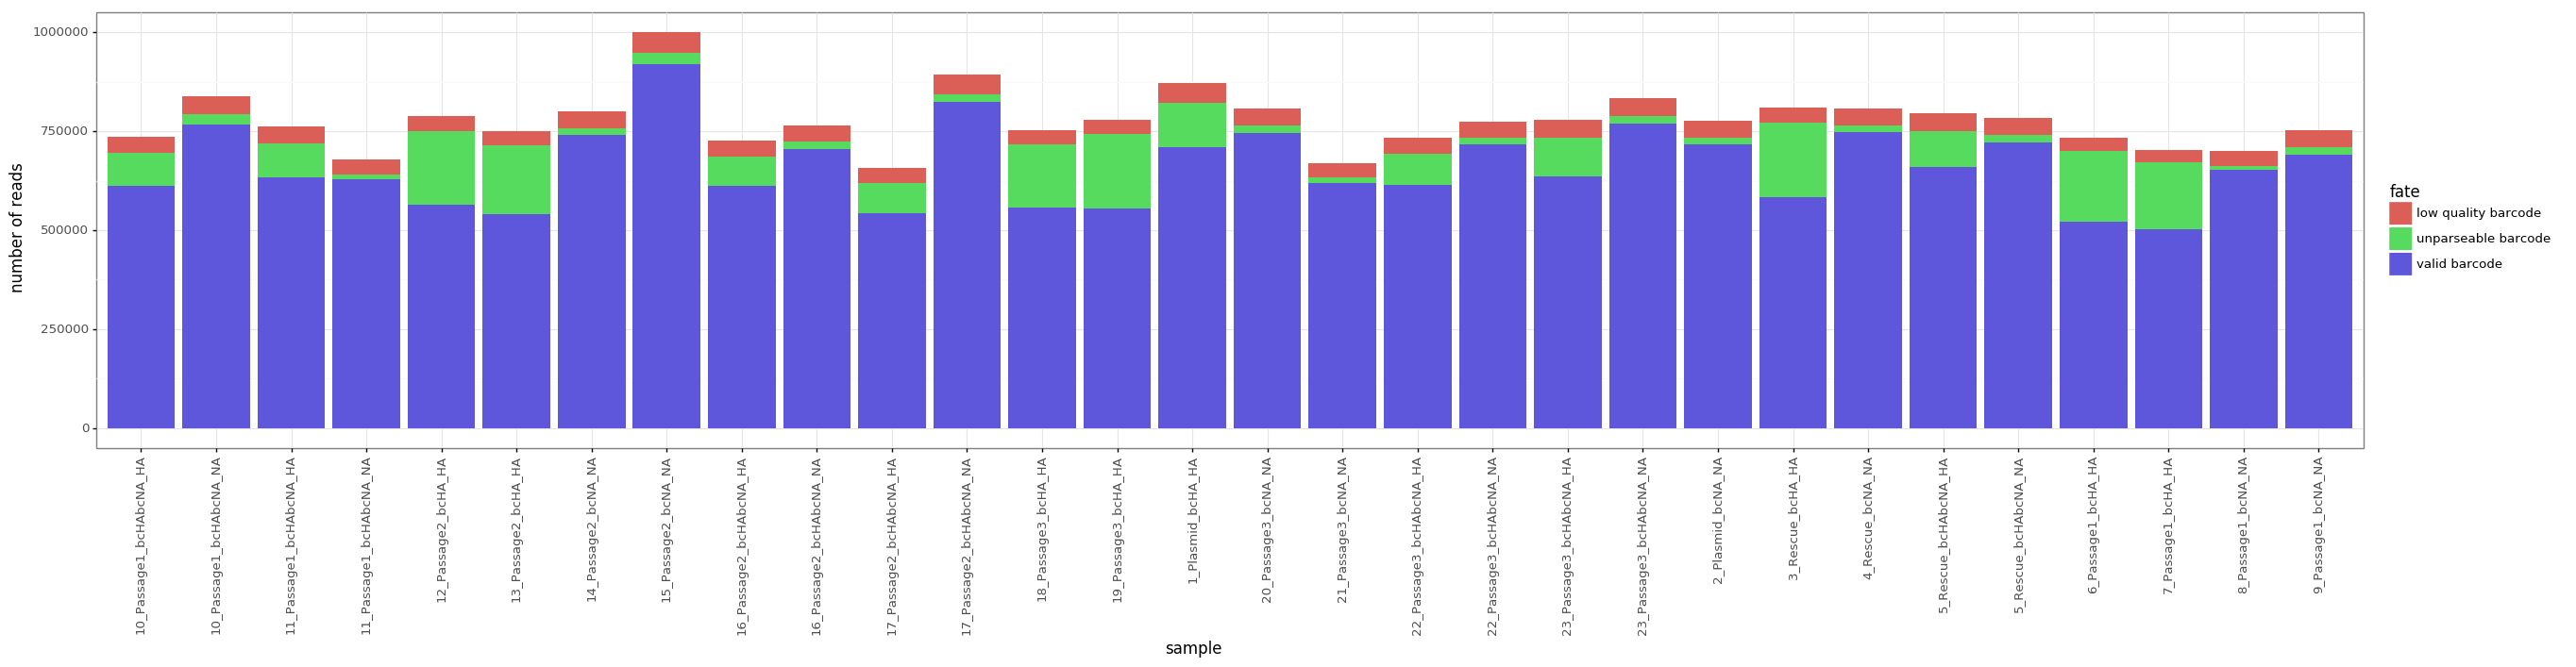

In [5]:
p = (
    ggplot(fates, aes('sample', 'count', fill='fate')) +
    geom_bar(stat='identity', position="stack") +
    ylab('number of reads') +
    theme(axis_text_x=element_text(angle=90),
          figure_size=(1 + len(fates['sample'].unique()), 6)) 
    )
_ = p.draw()

#### Interpretation
Each sample received ~750k reads. This is extremely deep coverage. The vast majority of barcodes are valid, so this run is of good quality and can be analyzed further.

### Load metadata
Want to load in information about how the experiments were prepared.  I'll load this from the separate metadata file,  calculate a few parameters, and join this onto the sample dataframe.

In [6]:
metadata = pd.read_csv(metadata_csv,comment="#")

pd.set_option('max.colwidth', -1)
display(HTML(metadata.to_html(index=False)))

sample_number,sample,barcoded_segments,step,replicate,titer,gene
3,3_Rescue_bcHA_HA,bcHA,Rescue,None,3162.278,fluHA
5,5_Rescue_bcHAbcNA_HA,bcHAbcNA,Rescue,None,6995.642,fluHA
6,6_Passage1_bcHA_HA,bcHA,Passage1,A,31622.777,fluHA
7,7_Passage1_bcHA_HA,bcHA,Passage1,B,42169.650,fluHA
10,10_Passage1_bcHAbcNA_HA,bcHAbcNA,Passage1,A,14677.993,fluHA
11,11_Passage1_bcHAbcNA_HA,bcHAbcNA,Passage1,B,144543.977,fluHA
12,12_Passage2_bcHA_HA,bcHA,Passage2,A,56234.133,fluHA
13,13_Passage2_bcHA_HA,bcHA,Passage2,B,100000.000,fluHA
16,16_Passage2_bcHAbcNA_HA,bcHAbcNA,Passage2,A,56234.133,fluHA
17,17_Passage2_bcHAbcNA_HA,bcHAbcNA,Passage2,B,23101.297,fluHA


In [7]:
samples = pd.merge(metadata, samples, how="outer")

## Select real barcodes
Next, we need to sub-select the real barcodes from the barcodes generated by PCR/sequencing errors. I expect to have a small number of barcodes (~20, based on how many colonies I picked) which are real and have many, many counts. Any other barcodes, with fewer counts, are spurious PCR or sequencing errors.

In [8]:
barcodes.columns = ['bc_rank','barcode','count','sample']
barcodes = pd.merge(barcodes, samples, how="outer")

barcodes[barcodes['bc_rank'] < 25].head(n=50)

,bc_rank,barcode,count,sample,sample_number,barcoded_segments,step,replicate,titer,gene,datatype,datafile
0,0,TATTCATTCCTCTTTC,126456,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
1,1,ATACCTCATGCTGAAG,66118,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
2,2,CGGAATATCATTGAGA,61886,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
3,3,TTATTTGTCCCTCGAA,56785,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
4,4,ATGTCGATTGTACTGC,49810,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
5,5,CCCCCGAATCCAGCAC,38755,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
6,6,CTGGTCATCCTTCACA,30951,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
7,7,TTATGCTGCATAACCG,28566,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
8,8,TGGGTCCAGTGGAGTA,27367,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz
9,9,ACAGCCGTGTATCCGA,18435,3_Rescue_bcHA_HA,3,bcHA,Rescue,None,3162.278,fluHA,viral_barcode_fastqs,3-Rescue-bcHA-HA_S1_L001_R1_001.fastq.gz


### Plot barcodes by count
In the barcode dataframe, barcodes are already in descending order of counts. I will plot them to see how the counts are distributed. I expect this to work like a knee plot, where I will see some number of highly-represented barcodes, which fall off to a lot of barcodes with low count numbers.

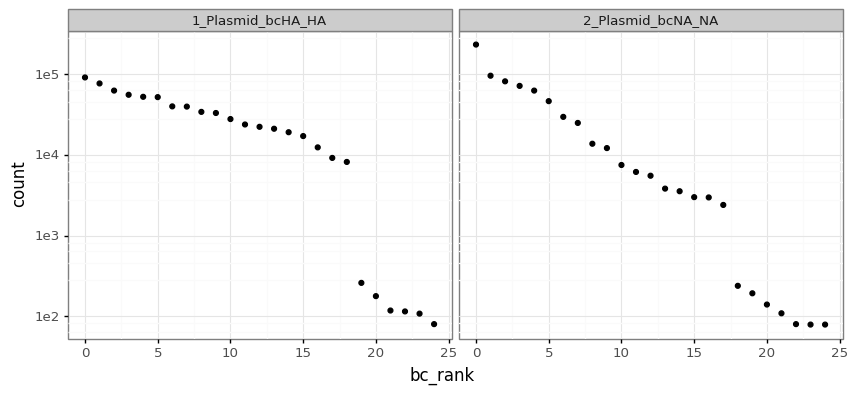

In [26]:
#First just look at plasmids
p = (
    ggplot(barcodes[(barcodes['step']=='Plasmid') & (barcodes['bc_rank'] < 25)], aes('bc_rank','count')) +
    geom_point() +
    scale_y_log10() +
    facet_wrap('~sample') +
    theme(figure_size=(10, 4)) 
)
    
_ = p.draw()

/fh/fast/bloom_j/software/conda/envs/BloomLab_v2/lib/python3.6/site-packages/plotnine/scales/scale.py:549: RuntimeWarning: divide by zero encountered in log10
  return self.trans.transform(x)


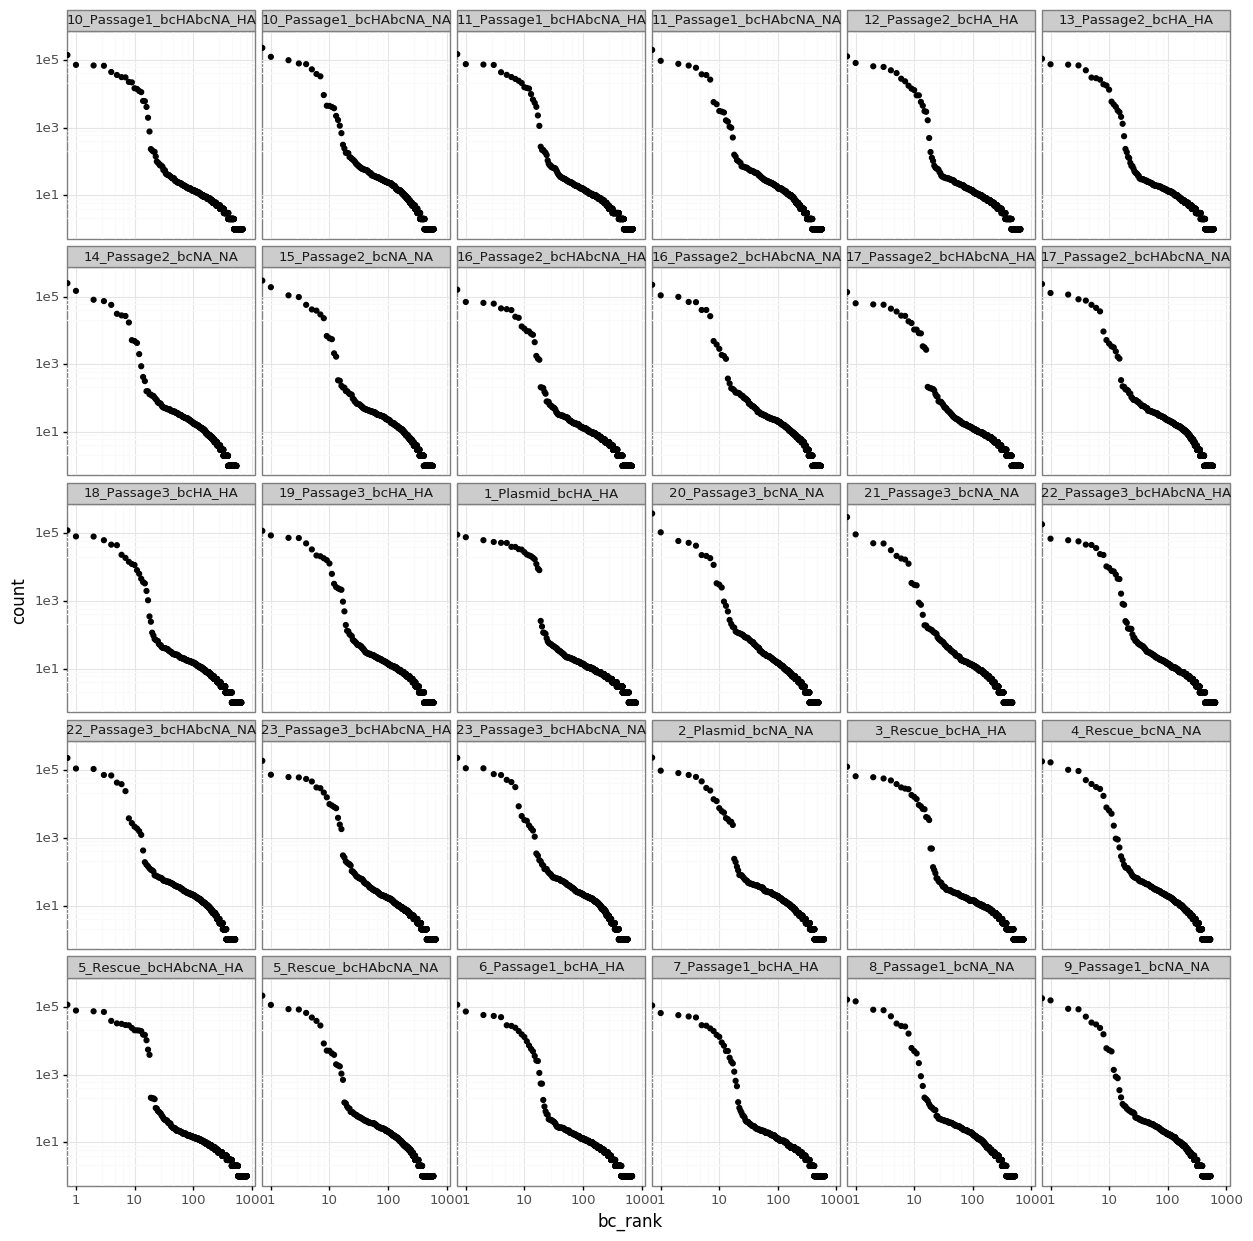

In [22]:
#Then look at all samples
p = (
    ggplot(barcodes, aes('bc_rank','count')) +
    geom_point() +
    scale_y_log10() + scale_x_log10() +
    facet_wrap('~sample') +
    theme(figure_size=(15, 15)) 
)
    
_ = p.draw()

#### Interpretation
The plot follows the general principles I would expect. There seem to be a bit fewer barcodes than I expected. Plots have a big jump between bc_rank 18 and 19 or bc_rank 17 and 18. Perhaps a few of the colonies I picked were duplicates? This seems statistically unlikely. Perhaps some clones didn't grow well in liquid media. This seems possible.

### Call real barcodes
Next, I will select which barcodes to actually analyze. As a simple first pass, I will use the highly-prevalent barcodes in the plasmid library to make a whitelist.

In [10]:
ha_whitelist = barcodes[barcodes['gene']=='fluHA']
ha_whitelist = ha_whitelist[(ha_whitelist['step']=='Plasmid')]
ha_whitelist = ha_whitelist[ha_whitelist['bc_rank']<19]
ha_whitelist = list(ha_whitelist.barcode)
ha_whitelist

['CGGAATATCATTGAGA',
 'CGTACCCGAATTATTC',
 'ATACCTCATGCTGAAG',
 'ACGTCAGCCCTGTCGG',
 'TATTCATTCCTCTTTC',
 'TTATTTGTCCCTCGAA',
 'ACAGCCGTGTATCCGA',
 'CCCCCGAATCCAGCAC',
 'TTATGCTGCATAACCG',
 'ATGTCGATTGTACTGC',
 'CTGGTCATCCTTCACA',
 'TTAAAGGCCAAGCATA',
 'TGGGTCCAGTGGAGTA',
 'GCTGCCATATCGTGTT',
 'ATGGGGTCTAATCTCC',
 'CTGGAATTCGCTCAAT',
 'CACCCATTCTGTGTGT',
 'CCAAGACCCATATCCC',
 'AATTCGGGTCAGCTTC']

In [11]:
na_whitelist = barcodes[barcodes['gene']=='fluNA']
na_whitelist = na_whitelist[na_whitelist['step']=='Plasmid']
na_whitelist = na_whitelist[na_whitelist['bc_rank']<18]
na_whitelist = list(na_whitelist.barcode)
na_whitelist

['TTAATTTTAAATACTG',
 'ATACCTATTTTCTACC',
 'GGGGTTTCGTACTCCA',
 'GGATTCTTGAATTTGC',
 'GAACGGGATGGCTTGA',
 'CTGAAACGCTAGGGGT',
 'CCCGGTTGGAGCAAAT',
 'CAACGAATTCTTTCAA',
 'CCTAGTCTGTACTACT',
 'CAGAAAGCTTGTTCAC',
 'CCTGACATGGGCTATA',
 'AAACAATTGATAGATC',
 'CGGGATATTTAATACA',
 'TATCATTACAACGACG',
 'AGAATGGATTTCAGTG',
 'AATCGCCTTGGCCACT',
 'GTCATTTGACCCAGGT',
 'ACAACCTTATACTCCA']

In [12]:
ha_barcodes = barcodes[barcodes['gene']=='fluHA']
ha_barcodes = ha_barcodes[ha_barcodes['barcode'].isin(ha_whitelist)]
ha_barcodes.to_csv('ha_barcode_counts.csv')

In [13]:
na_barcodes = barcodes[barcodes['gene']=='fluNA']
na_barcodes = na_barcodes[na_barcodes['barcode'].isin(na_whitelist)]
na_barcodes.to_csv('na_barcode_counts.csv')